In [1]:
#%env PYTHONHASHSEED=0
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import math

MAXLIFE = 100
SCALE = 1
RESCALE = 1
true_rul = []
test_engine_id = 0
training_engine_id = 0


def kink_RUL(cycle_list, max_cycle):
    '''
    Piecewise linear function with zero gradient and unit gradient

            ^
            |
    MAXLIFE |-----------
            |            \
            |             \
            |              \
            |               \
            |                \
            |----------------------->
    '''
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    stable_life = MAXLIFE
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - (stable_life / (max_cycle - knee_point))
            kink_RUL.append(tmp)

    return kink_RUL


def compute_rul_of_one_id(FD00X_of_one_id, max_cycle_rul=None):
    '''
    Enter the data of an engine_id of train_FD001 and output the corresponding RUL (remaining life) of these data.
    type is list
    '''

    cycle_list = FD00X_of_one_id['cycle'].tolist()
    if max_cycle_rul is None:
        max_cycle = max(cycle_list)  # Failure cycle
    else:
        max_cycle = max(cycle_list) + max_cycle_rul
        # print(max(cycle_list), max_cycle_rul)

    # return kink_RUL(cycle_list,max_cycle)
    return kink_RUL(cycle_list, max_cycle)


def compute_rul_of_one_file(FD00X, id='engine_id', RUL_FD00X=None):
    '''
    Input train_FD001, output a list
    '''
    rul = []
    # In the loop train, each id value of the 'engine_id' column
    if RUL_FD00X is None:
        for _id in set(FD00X[id]):
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id]))
        return rul
    else:
        rul = []
        for _id in set(FD00X[id]):
            # print("#### id ####", int(RUL_FD00X.iloc[_id - 1]))
            true_rul.append(int(RUL_FD00X.iloc[_id - 1]))
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id], int(RUL_FD00X.iloc[_id - 1])))
        return rul


def get_CMAPSSData(save=False, save_training_data=True, save_testing_data=True, files=[1, 2, 3, 4],
                   min_max_norm=False):
    '''
    :param save: switch to load the already preprocessed data or begin preprocessing of raw data
    :param save_training_data: same functionality as 'save' but for training data only
    :param save_testing_data: same functionality as 'save' but for testing data only
    :param files: to indicate which sub dataset needed to be loaded for operations
    :param min_max_norm: switch to enable min-max normalization
    :return: function will save the preprocessed training and testing data as numpy objects
    '''

    if save == False:
        return np.load("normalized_train_data.npy"), np.load("normalized_test_data.npy"), pd.read_csv(
            'normalized_train_data.csv', index_col=[0]), pd.read_csv('normalized_test_data.csv', index_col=[0])

    column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']

    if save_training_data:  ### Training ###

        train_FD001 = pd.read_table("train_FD001.txt", header=None, delim_whitespace=True)
        train_FD002 = pd.read_table("train_FD002.txt", header=None, delim_whitespace=True)
        train_FD003 = pd.read_table("train_FD003.txt", header=None, delim_whitespace=True)
        train_FD004 = pd.read_table("train_FD004.txt", header=None, delim_whitespace=True)
        train_FD001.columns = column_name
        train_FD002.columns = column_name
        train_FD003.columns = column_name
        train_FD004.columns = column_name

        previous_len = 0
        frames = []
        for data_file in ['train_FD00' + str(i) for i in files]:  # load subdataset by subdataset

            #### standard normalization ####
            mean = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].mean()
            std = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].std()
            std.replace(0, 1, inplace=True)
            # print("std", std)
            ################################

            if min_max_norm:
                scaler = MinMaxScaler()
                eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = scaler.fit_transform(
                    eval(data_file).iloc[:, 2:len(list(eval(data_file)))])
            else:
                eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = (eval(data_file).iloc[:, 2:len(
                    list(eval(data_file)))] - mean) / std

            eval(data_file)['RUL'] = compute_rul_of_one_file(eval(data_file))
            current_len = len(eval(data_file))
            # print(eval(data_file).index)
            eval(data_file).index = range(previous_len, previous_len + current_len)
            previous_len = previous_len + current_len
            # print(eval(data_file).index)
            frames.append(eval(data_file))
            print(data_file)

        train = pd.concat(frames)
        global training_engine_id
        training_engine_id = train['engine_id']
        train = train.drop('engine_id', 1)
        train = train.drop('cycle', 1)
        # if files[0] == 1 or files[0] == 3:
        #     train = train.drop('setting3', 1)
        #     train = train.drop('s18', 1)
        #     train = train.drop('s19', 1)

        train_values = train.values * SCALE
        np.save('normalized_train_data.npy', train_values)
        train.to_csv('normalized_train_data.csv')
        ###########
    else:
        train = pd.read_csv('normalized_train_data.csv', index_col=[0])
        train_values = train.values

    if save_testing_data:  ### testing ###

        test_FD001 = pd.read_table("test_FD001.txt", header=None, delim_whitespace=True)
        test_FD002 = pd.read_table("test_FD002.txt", header=None, delim_whitespace=True)
        test_FD003 = pd.read_table("test_FD003.txt", header=None, delim_whitespace=True)
        test_FD004 = pd.read_table("test_FD004.txt", header=None, delim_whitespace=True)
        test_FD001.columns = column_name
        test_FD002.columns = column_name
        test_FD003.columns = column_name
        test_FD004.columns = column_name

        # load RUL data
        RUL_FD001 = pd.read_table("RUL_FD001.txt", header=None, delim_whitespace=True)
        RUL_FD002 = pd.read_table("RUL_FD002.txt", header=None, delim_whitespace=True)
        RUL_FD003 = pd.read_table("RUL_FD003.txt", header=None, delim_whitespace=True)
        RUL_FD004 = pd.read_table("RUL_FD004.txt", header=None, delim_whitespace=True)
        RUL_FD001.columns = ['RUL']
        RUL_FD002.columns = ['RUL']
        RUL_FD003.columns = ['RUL']
        RUL_FD004.columns = ['RUL']

        previous_len = 0
        frames = []
        for (data_file, rul_file) in [('test_FD00' + str(i), 'RUL_FD00' + str(i)) for i in files]:
            mean = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].mean()
            std = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].std()
            std.replace(0, 1, inplace=True)

            if min_max_norm:
                scaler = MinMaxScaler()
                eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = scaler.fit_transform(
                    eval(data_file).iloc[:, 2:len(list(eval(data_file)))])
            else:
                eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = (eval(data_file).iloc[:, 2:len(
                    list(eval(data_file)))] - mean) / std

            eval(data_file)['RUL'] = compute_rul_of_one_file(eval(data_file), RUL_FD00X=eval(rul_file))
            current_len = len(eval(data_file))
            eval(data_file).index = range(previous_len, previous_len + current_len)
            previous_len = previous_len + current_len
            frames.append(eval(data_file))
            print(data_file)
            if len(files) == 1:
                global test_engine_id
                test_engine_id = eval(data_file)['engine_id']

        test = pd.concat(frames)
        test = test.drop('engine_id', 1)
        test = test.drop('cycle', 1)
        # if files[0] == 1 or files[0] == 3:
        #     test = test.drop('setting3', 1)
        #     test = test.drop('s18', 1)
        #     test = test.drop('s19', 1)

        test_values = test.values * SCALE
        np.save('normalized_test_data.npy', test_values)
        test.to_csv('normalized_test_data.csv')
        ###########
    else:
        test = pd.read_csv('normalized_test_data.csv', index_col=[0])
        test_values = test.values

    return train_values, test_values, train, test


def get_PHM08Data(save=False):
    """
    Function is to load PHM 2008 challenge dataset

    """

    if save == False:
        return np.load("./PHM08/processed_data/phm_training_data.npy"), np.load("./PHM08/processed_data/phm_testing_data.npy"), np.load(
            "./PHM08/processed_data/phm_original_testing_data.npy")

    column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
    phm_training_data = pd.read_table("./PHM08/train.txt", header=None, delim_whitespace=True)
    phm_training_data.columns = column_name
    phm_testing_data = pd.read_table("./PHM08/final_test.txt", header=None, delim_whitespace=True)
    phm_testing_data.columns = column_name

    print("phm training")
    mean = phm_training_data.iloc[:, 2:len(list(phm_training_data))].mean()
    std = phm_training_data.iloc[:, 2:len(list(phm_training_data))].std()
    phm_training_data.iloc[:, 2:len(list(phm_training_data))] = (phm_training_data.iloc[:, 2:len(
        list(phm_training_data))] - mean) / std
    phm_training_data['RUL'] = compute_rul_of_one_file(phm_training_data)

    print("phm testing")
    mean = phm_testing_data.iloc[:, 2:len(list(phm_testing_data))].mean()
    std = phm_testing_data.iloc[:, 2:len(list(phm_testing_data))].std()
    phm_testing_data.iloc[:, 2:len(list(phm_testing_data))] = (phm_testing_data.iloc[:, 2:len(
        list(phm_testing_data))] - mean) / std
    phm_testing_data['RUL'] = 0
    #phm_testing_data['RUL'] = compute_rul_of_one_file(phm_testing_data)

    train_engine_id = phm_training_data['engine_id']
    # print(phm_training_engine_id[phm_training_engine_id==1].index)
    phm_training_data = phm_training_data.drop('engine_id', 1)
    phm_training_data = phm_training_data.drop('cycle', 1)

    global test_engine_id
    test_engine_id = phm_testing_data['engine_id']
    phm_testing_data = phm_testing_data.drop('engine_id', 1)
    phm_testing_data = phm_testing_data.drop('cycle', 1)

    phm_training_data = phm_training_data.values
    phm_testing_data = phm_testing_data.values

    engine_ids = train_engine_id.unique()
    train_test_split = np.random.rand(len(engine_ids)) < 0.80
    train_engine_ids = engine_ids[train_test_split]
    test_engine_ids = engine_ids[~train_test_split]

    # test_engine_id = pd.Series(test_engine_ids)


    training_data = phm_training_data[train_engine_id[train_engine_id == train_engine_ids[0]].index]
    for id in train_engine_ids[1:]:
        tmp = phm_training_data[train_engine_id[train_engine_id == id].index]
        training_data = np.concatenate((training_data, tmp))
    # print(training_data.shape)

    testing_data = phm_training_data[train_engine_id[train_engine_id == test_engine_ids[0]].index]
    for id in test_engine_ids[1:]:
        tmp = phm_training_data[train_engine_id[train_engine_id == id].index]
        testing_data = np.concatenate((testing_data, tmp))
    # print(testing_data.shape)

    print(phm_training_data.shape, phm_testing_data.shape, training_data.shape, testing_data.shape)

    np.save("./PHM08/processed_data/phm_training_data.npy", training_data)
    np.savetxt("./PHM08/processed_data/phm_training_data.txt", training_data, delimiter=" ")
    np.save("./PHM08/processed_data/phm_testing_data.npy", testing_data)
    np.savetxt("./PHM08/processed_data/phm_testing_data.txt", testing_data, delimiter=" ")
    np.save("./PHM08/processed_data/phm_original_testing_data.npy", phm_testing_data)
    np.savetxt("./PHM08/processed_data/phm_original_testing_data.csv", phm_testing_data, delimiter=",")

    return training_data, testing_data, phm_testing_data




In [2]:
training_data, testing_data, training_pd, testing_pd = get_CMAPSSData(save=True, min_max_norm=True)

train_FD001
train_FD002
train_FD003
train_FD004
test_FD001
test_FD002
test_FD003
test_FD004


In [3]:
FD001_TRAIN_LENGTH = 20631
#FD001_TRAIN_LENGTH = 61042
FD002_TRAIN_LENGTH = 53759
FD003_TRAIN_LENGTH = 24720
FD004_TRAIN_LENGTH = 61249

FD_001_train_data = training_data[0:FD001_TRAIN_LENGTH][:]
#Remove column that are constant 
FD_001_train_data = np.delete(FD_001_train_data, [2,3, 7, 8, 12, 18, 20, 21], 1)
FD_001_X_train = FD_001_train_data[:, 0:-1]
FD_001_Y_train = FD_001_train_data[:, -1]

# Split into train-validation 90/10 ratio
X_train = FD_001_X_train[0:math.ceil(FD001_TRAIN_LENGTH*0.9)]
X_val = FD_001_X_train[math.ceil(FD001_TRAIN_LENGTH*0.9):]

y_train = FD_001_Y_train[0:math.ceil(FD001_TRAIN_LENGTH*0.9)]
y_val = FD_001_Y_train[math.ceil(FD001_TRAIN_LENGTH*0.9):]

In [4]:
FD001_TEST_LENGTH = 13096
FD002_TEST_LENGTH = 33991
FD003_TEST_LENGTH = 16596
FD004_TEST_LENGTH = 41214

FD_001_test_data = testing_data[0:FD001_TEST_LENGTH][:]
#Remove column that are constant 
FD_001_test_data = np.delete(FD_001_test_data, [2,3, 7, 8, 12, 18, 20, 21], 1)
X_test = FD_001_test_data[:, 0:-1]
y_test = FD_001_test_data[:, -1]

In [5]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

window_size = 30

train_data = TimeseriesGenerator(X_train, y_train,
                               length=window_size, sampling_rate=1,
                               batch_size=window_size)

val_data = TimeseriesGenerator(X_val, y_val,
                               length=window_size, sampling_rate=1,
                               batch_size=window_size)

test_data = TimeseriesGenerator(X_test, y_test,
                               length=window_size, sampling_rate=1,
                               batch_size=window_size)

In [6]:
x, y=train_data[0]
x.shape

(30, 30, 16)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, TimeDistributed

import tensorflow.keras.backend as K

In [8]:
nb_features = FD_001_X_train.shape[1]
nb_out = 1
model = tf.keras.Sequential()

#Bi-directional LSTM

# model.add(Bidirectional(layers.LSTM(units=50, return_sequences=True),input_shape=(window_size, nb_features)))
# model.add(Bidirectional(layers.LSTM(units=25)))
# model.add(layers.Dense(units=50))
# model.add(layers.Dropout(0.2))
# model.add(layers.Activation("relu"))
# model.add(layers.Dense(units=nb_out))
# model.add(layers.Activation("relu"))

#CNN1D
model.add(layers.Conv1D(60,2, activation='relu', data_format='channels_last', input_shape=(window_size, nb_features)))
model.add(layers.Conv1D(60,2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(nb_out, activation='relu'))

# 	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# 	model.add(Dropout(0.5))
# 	model.add(MaxPooling1D(pool_size=2))
# 	model.add(Flatten())
# 	model.add(Dense(100, activation='relu'))

# #basic dnn
# model.add(layers.Dense(100, input_shape=(window_size, nb_features), kernel_regularizer=regularizers.l2(0.0001)))
# model.add(layers.Dense(250, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(layers.Dense(12, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(layers.Dense(6, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(layers.Dense(4, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(nb_out, activation='relu'))


#GRU
# model.add(Bidirectional(GRU(units=100,return_sequences=True),input_shape=(window_size, nb_features)))
# model.add(Dropout(0.2))
# model.add(Bidirectional(GRU(units=50)))
# model.add(Dropout(0.2))
# model.add(Dense(units=20))
# model.add(Activation("relu"))
# #model.add(LeakyReLU(alpha=0.3))
# model.add(Dense(units=nb_out))
# model.add(Activation("relu"))
# #model.add(LeakyReLU(alpha=0.3))
# model.add(Dense(nb_out, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 60)            1980      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 60)            7260      
_________________________________________________________________
dropout (Dropout)            (None, 28, 60)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 60)            0         
_________________________________________________________________
flatten (Flatten)            (None, 840)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               84100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [9]:
###########################################
############# custom loss #################
###########################################
def msle_mse(y_true, y_pred):
    w = K.switch(
        K.less(K.sum(K.mean(y_pred, axis=0))-K.sum(K.mean(y_true, axis=0)), 0),
        K.sum(K.mean(K.square(K.log(y_true+1)-K.log(y_pred+1)), axis=0)),
        K.sum(K.mean(K.square(y_true-y_pred), axis=0))
    )
    return w

def mse_mse(y_true, y_pred):
    w = K.switch(
        K.less(K.sum(K.mean(y_pred))-K.sum(K.mean(y_true)), 0),
        K.sum(K.mean(K.square(y_true-y_pred))),
        K.sum(K.mean(K.square(y_true-y_pred)))
    )
    return w

def msle_msle(y_true, y_pred):
    w = K.switch(
        K.less(K.sum(K.mean(y_pred))-K.sum(K.mean(y_true)), 0),
        K.mean(K.sum(K.square(K.log(y_true+1)-K.log(y_pred+1)))),
        K.mean(K.sum(K.square(K.log(y_true+1)-K.log(y_pred+1))))
    )
    return w

def mae_mae(y_true, y_pred):
    w = K.switch(
        K.less(K.sum(K.mean(y_pred))-K.sum(K.mean(y_true)), 0),
        K.sum(K.mean(K.abs(y_true-y_pred))),
        K.sum(K.mean(K.abs(y_true-y_pred)))
    )
    return w

# def linlin(y_true, y_pred):
#     b = 1
#     a = 0.01
#     w = K.switch(
#         K.less(K.sum(K.mean(y_pred-y_true)), 0),
#         -a*(K.sum(K.mean(y_pred-y_true))),
#         a*(K.sum(K.mean(y_pred-y_true)))
#     )
#     return w

def lin_mse(y_true, y_pred):
    a = 0.5
    w = K.switch(
        K.less(K.sum(K.mean(y_pred-y_true)), 0),
        -a*(K.sum(K.mean(y_pred-y_true))),
        K.sum(K.mean(K.square(y_true-y_pred), axis=0))
    )
    return w

def lin_lin(y_true, y_pred):
    a = 2
    c = 6
    w = K.switch(
        K.less(K.sum(K.mean(y_pred-y_true)), 0),
        -a*(K.sum(K.mean(y_pred-y_true))),
        c*(K.sum(K.mean(y_pred-y_true)))
    )
    return w

def quad_quad(y_true, y_pred):
    a = 0.3
    w = K.switch(
        K.less(K.sum(K.mean(y_pred-y_true)), 0),
        (K.sum(K.mean(2*(a)*K.square(y_pred-y_true)))),
        (K.sum(K.mean(2*(a+(1-(2*a)))*K.square(y_pred-y_true))))
    )
    return w


###########################################
############# custom metrics ##############
###########################################

def SF(y_true, y_pred):
    s = K.switch(
        K.less(K.sum(y_pred-y_true), 0),
        K.sum(K.exp((-(y_pred-y_true)/13))-1),
        K.sum(K.exp(((y_pred-y_true)/10))-1)
    )
    return s

In [10]:
model.compile(loss=quad_quad, optimizer='nadam' ,metrics=[SF])

In [11]:

# define path to save model
model_path = 'lstm_regression__cmapss_model.h5'

#reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_SF', min_delta=0, patience=50, verbose=0, mode='min', restore_best_weights=True)
mcp_save = keras.callbacks.ModelCheckpoint(model_path,monitor='val_SF', save_best_only=True, mode='min', verbose=0)

# fit the network
import time
start=time.time()
history = model.fit_generator(train_data, epochs=1000, validation_data=val_data, verbose=1, shuffle=False,
          callbacks = [earlyStopping, mcp_save]
          )
end=time.time()
print('Total Training Time: ', end-start)
# list all data in history
print(history.history.keys())

Epoch 1/1000
618/618 [==============================] - 34s 55ms/step - loss: 686.5093 - SF: 1207.9207 - val_loss: 582.2208 - val_SF: 544.5007
Epoch 2/1000
618/618 [==============================] - 30s 49ms/step - loss: 330.6083 - SF: 318.3652 - val_loss: 564.4234 - val_SF: 464.9812
Epoch 3/1000
618/618 [==============================] - 32s 52ms/step - loss: 304.0152 - SF: 276.5646 - val_loss: 594.6680 - val_SF: 468.2267
Epoch 4/1000
618/618 [==============================] - 34s 55ms/step - loss: 293.0932 - SF: 249.7817 - val_loss: 631.0691 - val_SF: 515.3652
Epoch 5/1000
618/618 [==============================] - 36s 58ms/step - loss: 289.9756 - SF: 243.0623 - val_loss: 661.9746 - val_SF: 529.7579
Epoch 6/1000
618/618 [==============================] - 34s 55ms/step - loss: 280.9589 - SF: 223.8663 - val_loss: 656.4210 - val_SF: 506.3930
Epoch 7/1000
618/618 [==============================] - 37s 60ms/step - loss: 280.3428 - SF: 217.1742 - val_loss: 700.3873 - val_SF: 547.2037
Epoch

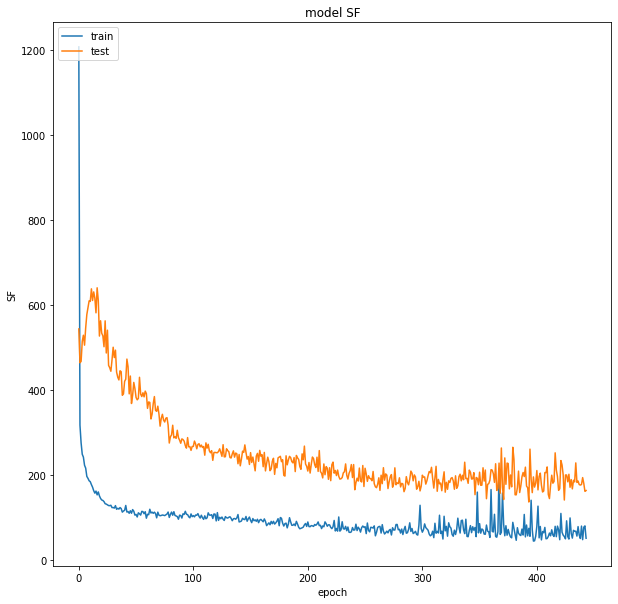

In [12]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['SF'])
plt.plot(history.history['val_SF'])
plt.title('model SF')
plt.ylabel('SF')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_CNN1D.png")


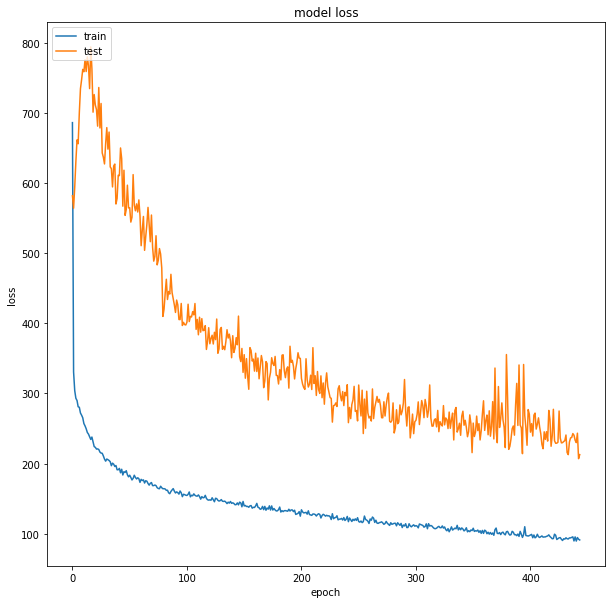

In [13]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_CNN1D_loss.png")

In [14]:
# test metrics
scores_test = model.evaluate_generator(test_data, verbose=2)
print('\nSF: {}'.format(scores_test[1]))

436/436 - 7s - loss: 865.1257 - SF: 1565.2351

SF: 1565.235107421875


In [15]:
predict = model.predict_generator(test_data)
predict.shape

(13066, 1)

In [16]:
# helper function to get y from generator data
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [17]:
actual = get_y_from_generator(test_data)

(13066, 1)


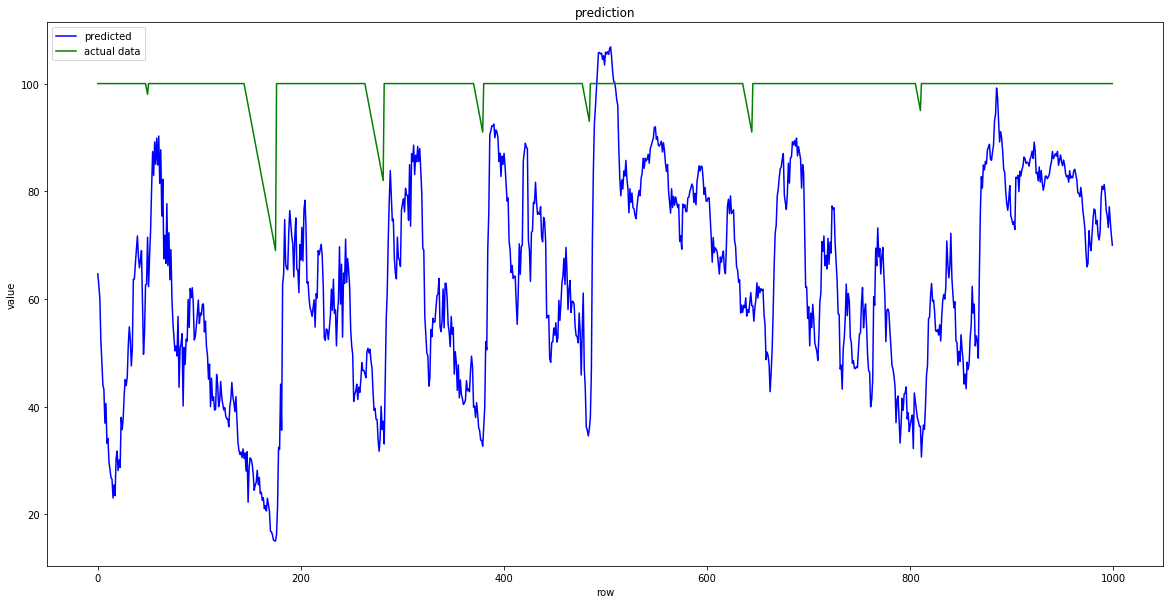

In [18]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(20, 10))
plt.plot(predict[0:1000], color="blue")
plt.plot(actual[0:1000], color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_CNN1D_verify.png")

In [19]:
# Using the scoring function

def scoring_function(true, pred):
    d = pred - true
    length = len(d)
    s = 0
    num = []
    for i in range(length):
        if(i != length-1 and true[i]-true[i+1]<0):
            if (d[i] < 0):
                s += np.exp((-d[i]/13))-1
            else:
                s += np.exp((d[i]/10))-1
            num.append(i)
    return s, num

def rmse(true, pred):
    d_squared = (pred - true)**2
    length = len(d_squared)
    err = 0
    for i in range(length):
        err += d_squared[i]
    err = np.sqrt(err/length)
    return err

In [20]:
sf, num = scoring_function(actual,predict)
rmse_err = rmse(actual,predict)

In [21]:
print(sf,rmse_err)

[47570.83116727] [37.45396628]
